# Machine Learning for Oil Exploration

## Table of Contents <a id='back'></a>

* [1. Introduction](#intro)
* [2. Initiation](#init)
* [3. Data Overview](#overview)
* [4. Preprocessing](#pre)
* [5. Model Training and Validation](#train)
* [6. Profit Calculation](#cal)
	* [6.1. Average Oil Volume Requirement and Production](#1)
	* [6.2. Profit Calculation](#2)
	* [6.3. Loss Risk Mitigation](#3)
	* [6.4. Risk and Profit for Each Area](#4)
* [7. General Conclusion](#end)

## 1. Introduction

### 1.1. Project Description

Working for an oil mining company called OilyGiant, the task is to find a suitable location for drilling a new oil well.
The following are the steps to select a new location:
1. Collect parameters to build an oil well in several selected regions: oil quality and oil reserve volume;
2. Create a model that can predict the volume of oil reserves in a new well;
3. Select the oil well with the highest estimated value;
4. Select the region with the highest total profit for the selected oil well.

You have oil sample data from three regions. The parameters of each oil well in those regions are already known. Create a model that will help you choose the region with the highest profit margin. Analyze the potential profit and risks using the bootstrapping technique.

### 1.2. Objectives

The objectives of this research are:
1. Creating a model that can predict the volume of oil reserves in a new well;
2. Selecting the oil well with the highest estimated value;
3. Selecting the region with the highest total profit for the selected oil well.

### 1.3. Dataset Description

The geological exploration data for the three areas are stored in several files:
* geo_data_0.csv; geo_data_1.csv; geo_data_2.csv.

Each of them consists of these variables:
* id - unique ID of oil well;
* f0, f1, f2 - three point features (specific meaning is not important, but the feature itself is significant);
* product - volume of oil reserves in the well (thousands of barrels).

### 1.4. Methodology

The steps for this research are:
1. Data preprocessing;
2. Training and testing the prediction model for each area;
3. Calculating profit/loss based on predictions;
4. Oil well locations proposal;
5. Simulating profit/loss distribution with bootstrapping;
6. Result and conclusion.

[back to table of contents](#back)

## 2. Initiation <a id='init'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as st

np.random.seed(123)
state = np.random.RandomState(123)

In [2]:
df1 = pd.read_csv('datasets/geo_data_0.csv')
df2 = pd.read_csv('datasets/geo_data_1.csv')
df3 = pd.read_csv('datasets/geo_data_2.csv')

[back to table of contents](#back)

## 3. Data Overview <a id='overview'></a>

### Geo Data 1

In [3]:
df1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


There are 100,000 rows and 5 columns in this dataset. There is no missing value, and all of the data is in the right data type. Since we are not given what f0, f1, and f2 is about, we assume these columns are not redundant.

In [5]:
df1.duplicated().sum()

0

There is no duplicated column.

In [6]:
df1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


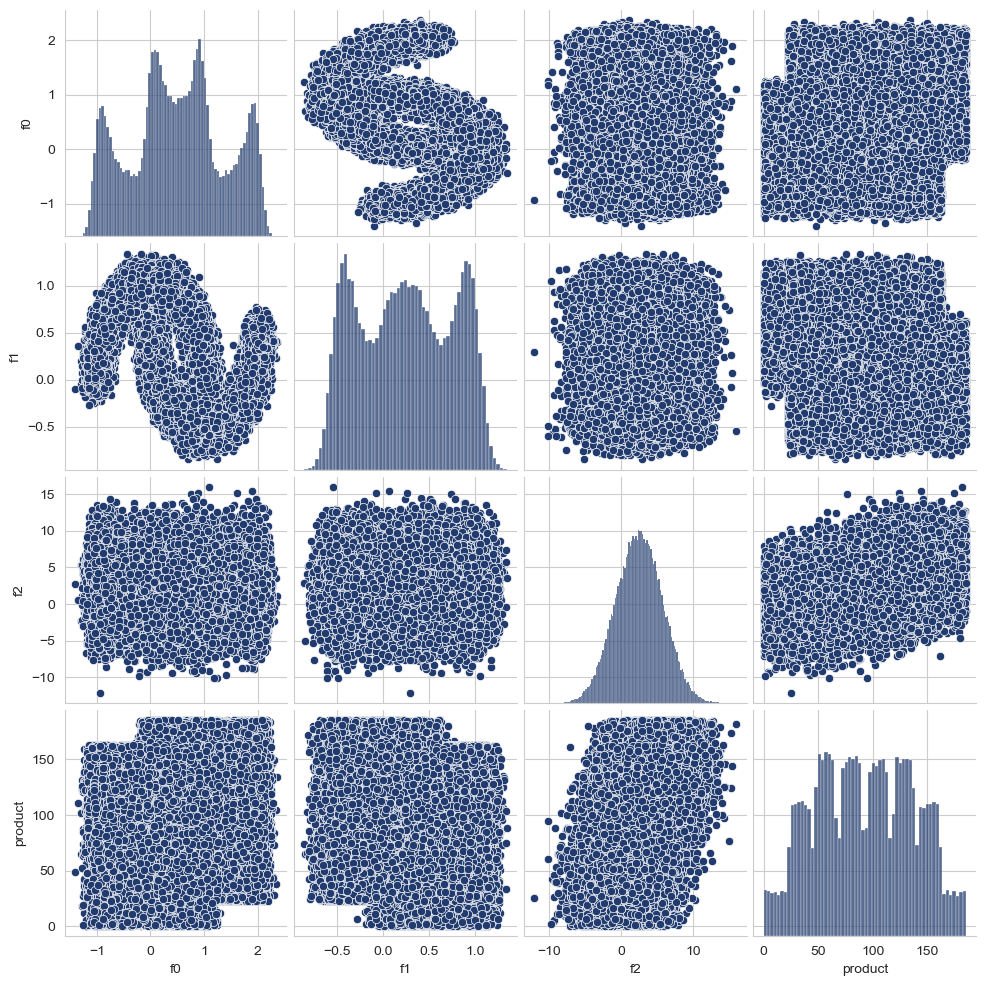

In [7]:
sns.set_style('whitegrid')
sns.set_palette('cividis')
sns.pairplot(data=df1, vars=['f0','f1','f2','product'], kind='scatter', diag_kind='hist')
plt.show()

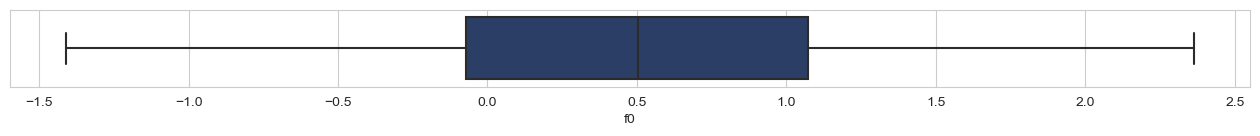

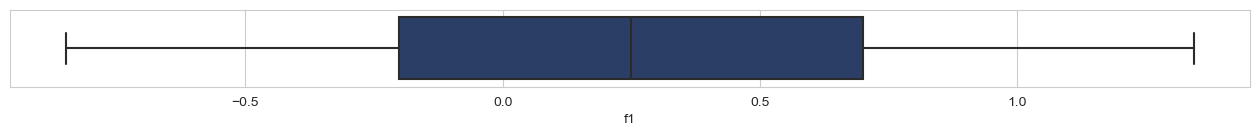

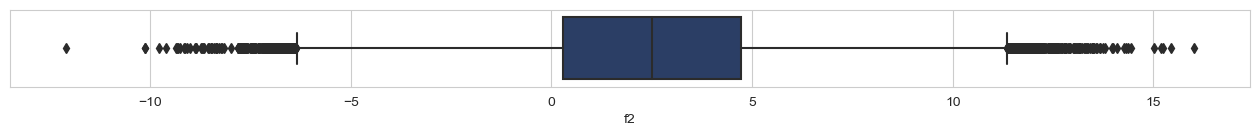

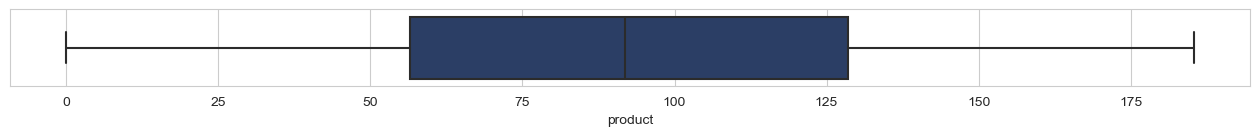

In [8]:
plt.figure(figsize=(16,1))
sns.boxplot(data=df1, x='f0')
plt.show()
plt.figure(figsize=(16,1))
sns.boxplot(data=df1, x='f1')
plt.show()
plt.figure(figsize=(16,1))
sns.boxplot(data=df1, x='f2')
plt.show()
plt.figure(figsize=(16,1))
sns.boxplot(data=df1, x='product')
plt.show()

Since, we aren't given what the feature data is about, we will assume that there is no outlier.

### Geo Data 2

In [9]:
df2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


There are 100,000 rows and 5 columns in this dataset. There is no missing value, and all of the data is in the right data type. Since we are not given what f0, f1, and f2 is about, we assume these columns are not redundant.

In [11]:
df2.duplicated().sum()

0

There is no duplicated column.

In [12]:
df2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


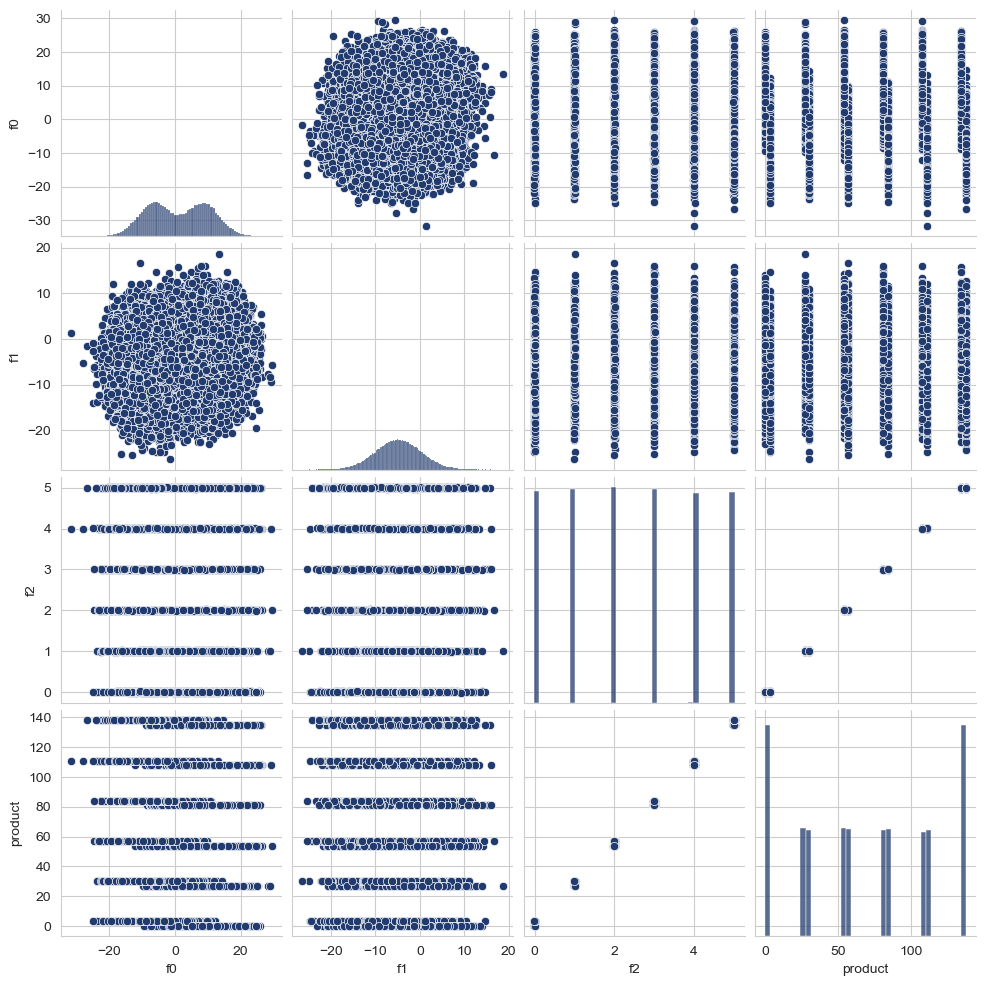

In [13]:
sns.pairplot(data=df2, vars=['f0','f1','f2','product'], kind='scatter', diag_kind='hist')
plt.show()

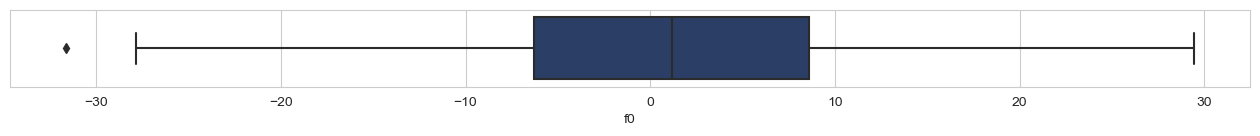

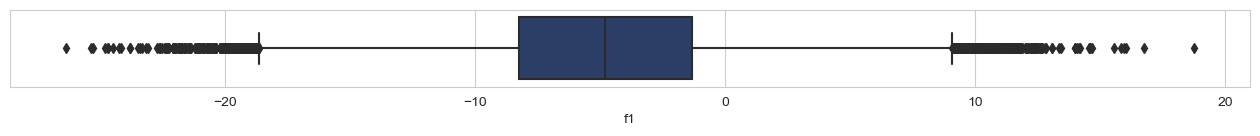

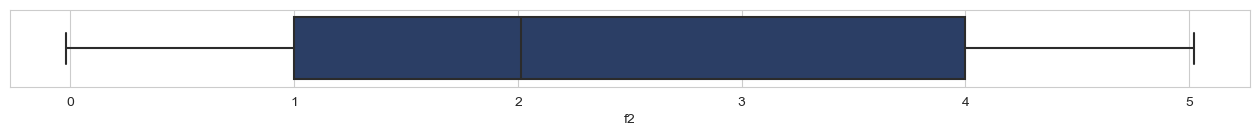

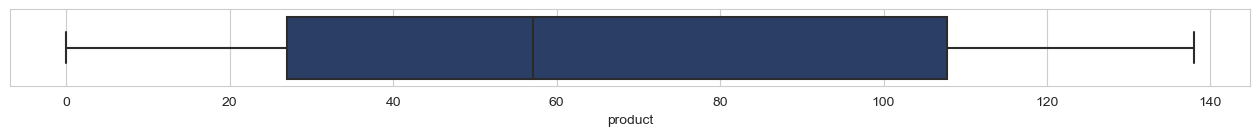

In [14]:
plt.figure(figsize=(16,1))
sns.boxplot(data=df2, x='f0')
plt.show()
plt.figure(figsize=(16,1))
sns.boxplot(data=df2, x='f1')
plt.show()
plt.figure(figsize=(16,1))
sns.boxplot(data=df2, x='f2')
plt.show()
plt.figure(figsize=(16,1))
sns.boxplot(data=df2, x='product')
plt.show()

### Geo Data 3

In [15]:
df3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [16]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


There are 100,000 rows and 5 columns in this dataset. There is no missing value, and all of the data is in the right data type. Since we are not given what f0, f1, and f2 is about, we assume these columns are not redundant.

In [17]:
df3.duplicated().sum()

0

There is no duplicated column.

In [18]:
df3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


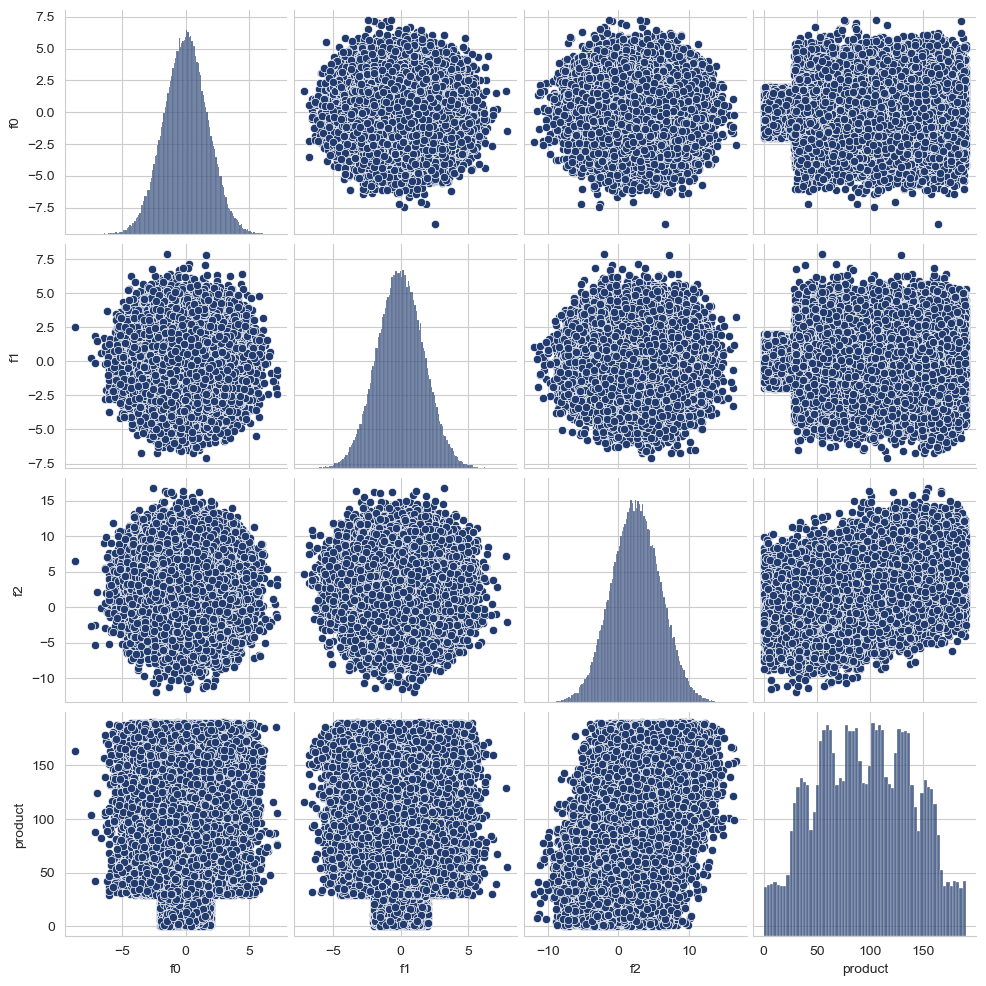

In [19]:
sns.pairplot(data=df3, vars=['f0','f1','f2','product'], kind='scatter', diag_kind='hist')
plt.show()

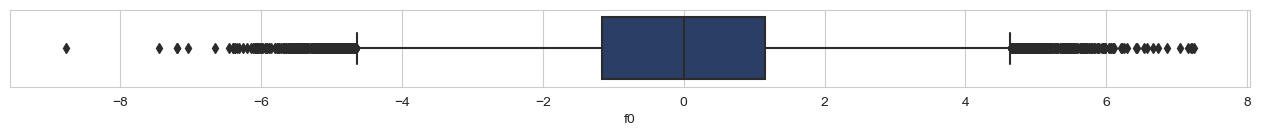

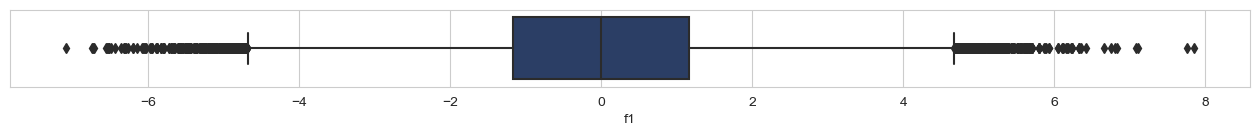

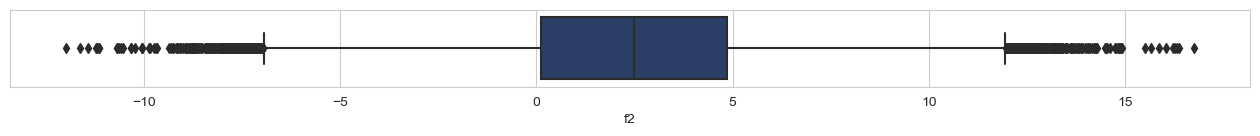

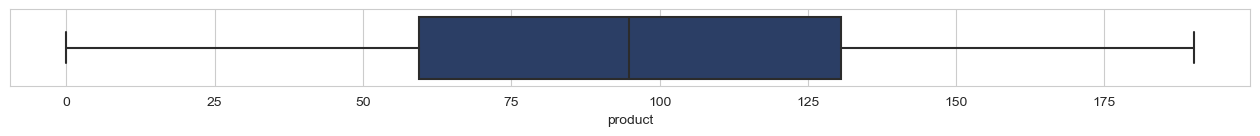

In [20]:
plt.figure(figsize=(16,1))
sns.boxplot(data=df3, x='f0')
plt.show()
plt.figure(figsize=(16,1))
sns.boxplot(data=df3, x='f1')
plt.show()
plt.figure(figsize=(16,1))
sns.boxplot(data=df3, x='f2')
plt.show()
plt.figure(figsize=(16,1))
sns.boxplot(data=df3, x='product')
plt.show()

[back to table of contents](#back)

## 4. Preprocessing <a id='pre'></a>

The range for numerical features seems to be close to one another so there is no need to perform standardization. In addition, since there is no categorical variable, there is no need to encode anything.

### 4.1. Defining Dataset

In this section, we split the dataset into training and validation dataset. 

In [21]:
features1 = df1[['f0','f1','f2']]
target1 = df1['product']
features2 = df2[['f0','f1','f2']]
target2 = df2['product']
features3 = df3[['f0','f1','f2']]
target3 = df3['product']

In [22]:
features_train1, features_valid1, target_train1, target_valid1 = train_test_split(features1, target1, test_size=0.25, random_state=state)
features_train2, features_valid2, target_train2, target_valid2 = train_test_split(features2, target2, test_size=0.25, random_state=state)
features_train3, features_valid3, target_train3, target_valid3 = train_test_split(features3, target3, test_size=0.25, random_state=state)

[back to table of contents](#back)

## 5. Model Training and Validation <a id='train'></a>

Linear regression model for the first area dataset:

In [23]:
model1 = LinearRegression()
model1.fit(features_train1,target_train1)
predicted_valid1 = model1.predict(features_valid1)
rmse1 = mean_squared_error(target_valid1, predicted_valid1) **0.5
r2_1 = r2_score(target_valid1, predicted_valid1)

print(f'Average predicted volume of oil = {predicted_valid1.mean():.2f} thousands of barrels')
print(f'RMSE for linear regression model = {rmse1:.2f} thousands of barrels')
print(f'R2 for linear regression model = {r2_1:.2f}')

Average predicted volume of oil = 92.55 thousands of barrels
RMSE for linear regression model = 37.65 thousands of barrels
R2 for linear regression model = 0.28


The first dataset prediction has the average of 92.55 MBBL and the RMSE of 37.65 MBBL shows that the predictions are quite far from the actual values. The R2 score of 0.28 means that the model generated can only interpret a few actual values correctly.

Linear regression model for the second area dataset:

In [24]:
model2 = LinearRegression()
model2.fit(features_train2,target_train2)
predicted_valid2 = model2.predict(features_valid2)
rmse2 = mean_squared_error(target_valid2, predicted_valid2) **0.5
r2_2 = r2_score(target_valid2, predicted_valid2)

print(f'Average predicted volume of oil = {predicted_valid2.mean():.2f} thousands of barrels')
print(f'RMSE for linear regression model = {rmse2:.2f} thousands of barrels')
print(f'R2 for linear regression model = {r2_2:.2f}')

Average predicted volume of oil = 69.03 thousands of barrels
RMSE for linear regression model = 0.89 thousands of barrels
R2 for linear regression model = 1.00


The second dataset prediction has the average of 69.03 MBBL and the RMSE of 0.89 MBBL shows that the predictions are close to the actual values. The R2 score of 1 means that the model generated is perfectly suited to predict the actual values.

Linear regression model for the third area dataset:

In [25]:
model3 = LinearRegression()
model3.fit(features_train3,target_train3)
predicted_valid3 = model3.predict(features_valid3)
rmse3 = mean_squared_error(target_valid3, predicted_valid3) **0.5
r2_3 = r2_score(target_valid3, predicted_valid3)

print(f'Average predicted volume of oil = {predicted_valid3.mean():.2f} thousands of barrels')
print(f'RMSE for linear regression model = {rmse3:.2f} thousands of barrels')
print(f'R2 for linear regression model = {r2_3:.2f}')

Average predicted volume of oil = 95.06 thousands of barrels
RMSE for linear regression model = 40.02 thousands of barrels
R2 for linear regression model = 0.20


The third dataset prediction has the average of 95.06 MBBL and the RMSE of 40.02 MBBL shows that the predictions are quite far from the actual values. The R2 score of 0.2 means that the model generated can only interpret a few actual values correctly.

The third area has the highest average production prediction out of all. It surpass the first area by about 2.5 MBBL, and the second area by 25 MBBL. However it also has the largest variation out of all with the typical error in prediction of 40.02 MBBL.

[back to table of contents](#back)

## 6. Profit Calculation <a id='cal'></a>

### 6.1. Average Oil Volume Requirement and Production <a id='1'></a>

In [26]:
budget_for_200 = 100000000
price_per_mbbl = 4500

In [27]:
total_breakeven_volume = budget_for_200/price_per_mbbl
f'The total volume of oil generated from 200 wells to breakeven should be {total_breakeven_volume:,.2f} MBBL'

'The total volume of oil generated from 200 wells to breakeven should be 22,222.22 MBBL'

In [28]:
breakeven_volume_per_well = total_breakeven_volume/200
f'On average, it will be required to have {breakeven_volume_per_well:.2f} MBBL per well to breakeven'

'On average, it will be required to have 111.11 MBBL per well to breakeven'

In [29]:
print('The average predicted oil generated from first area is {:.2f} MBBL per well'.format(predicted_valid1.mean()))
print('The average predicted oil generated from second area is {:.2f} MBBL per well'.format(predicted_valid2.mean()))
print('The average predicted oil generated from third area is {:.2f} MBBL per well'.format(predicted_valid3.mean()))

The average predicted oil generated from first area is 92.55 MBBL per well
The average predicted oil generated from second area is 69.03 MBBL per well
The average predicted oil generated from third area is 95.06 MBBL per well


In [30]:
df_predict_valid = pd.DataFrame({'mean':[predicted_valid1.mean(),predicted_valid2.mean(),predicted_valid3.mean()],
                                'std':[predicted_valid1.std(ddof=1),predicted_valid2.std(ddof=1),predicted_valid3.std(ddof=1)]},
                                index=['1','2','3'])
df_predict_valid.index.name = 'area'
df_predict_valid

,mean,std
area,,
1,92.549362,23.417413
2,69.032533,46.007834
3,95.055955,19.841552


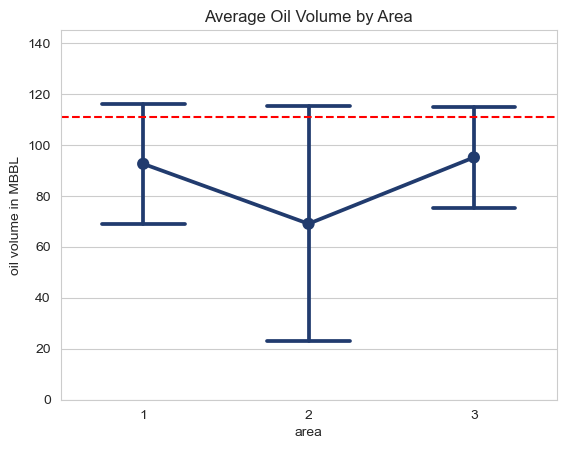

In [31]:
fig, ax = plt.subplots()
sns.pointplot(data=[predicted_valid1,predicted_valid2,predicted_valid3], ci='sd',capsize=.5)
ax.axhline(y=float(breakeven_volume_per_well), linestyle='--', color='r')
ax.set_title('Average Oil Volume by Area')
ax.set(xlabel='area',ylabel='oil volume in MBBL',xticklabels=[1,2,3],ylim=(0,145))
plt.show()

Based on the average volume of oil generated, the third area is the most profitable, followed by the first area and then the second area.

[back to table of contents](#back)

### 6.2. Profit Calculation <a id='2'></a>

In [32]:
counts = 200

In [33]:
def profit_calc(target,prediction):
    predict_sorted = pd.Series(prediction, index=target.index).sort_values(ascending=False)
    selected_target = target[predict_sorted.index][:counts]
    profit = selected_target.sum()*price_per_mbbl - budget_for_200
    return profit

In [34]:
profit_200_area_1 = profit_calc(target_valid1, predicted_valid1)
profit_200_area_2 = profit_calc(target_valid2, predicted_valid2)
profit_200_area_3 = profit_calc(target_valid3, predicted_valid3)

print(f'Actual profit from top 200 wells in the first area = {profit_200_area_1:,.2f} USD')
print(f'Actual profit from top 200 wells in the second area = {profit_200_area_2:,.2f} USD')
print(f'Actual profit from top 200 wells in the third area = {profit_200_area_3:,.2f} USD')

Actual profit from top 200 wells in the first area = 35,346,709.17 USD
Actual profit from top 200 wells in the second area = 24,150,866.97 USD
Actual profit from top 200 wells in the third area = 24,760,063.82 USD


In [35]:
df_all = pd.concat([
         pd.DataFrame({'t':target_valid1, 'p':predicted_valid1, 'a':'1'}),
         pd.DataFrame({'t':target_valid2, 'p':predicted_valid2, 'a':'2'}),
         pd.DataFrame({'t':target_valid3, 'p':predicted_valid3, 'a':'3'})
         ])

print('Considering all area, the top 200 wells with highest production predictions are distributed in these areas:')
df_all.sort_values(by='p',ascending=False).head(200)['a'].value_counts(normalize=True)

Considering all area, the top 200 wells with highest production predictions are distributed in these areas:


1    0.735
3    0.265
Name: a, dtype: float64

In [36]:
profit_200_all = profit_calc(df_all['t'], df_all['p'])
f'Actual profit from top 200 wells in all area = {profit_200_all:,.2f} USD'

'Actual profit from top 200 wells in all area = 13,679,380.84 USD'

The actual profit from investing all budget in the first area is still higher than the profit from all areas combined. This is because the model predicted higher score than actual for the second area.

[back to table of contents](#back)

### 6.3. Loss Risk Mitigation <a id='3'></a>

The maximum acceptable risk of loss is 2.5%.

In [37]:
loss_threshold = -0.025

In [38]:
minimum_acc_total_profit = budget_for_200 * loss_threshold
minimum_acc_total_revenue = budget_for_200 + minimum_acc_total_profit
minimum_acc_avg_revenue = minimum_acc_total_revenue/200
minimum_acc_avg_product = minimum_acc_avg_revenue/4500
print(f'Minimum acceptable total profit = {minimum_acc_total_profit:,} USD')
print(f'Minimum acceptable total revenue = {minimum_acc_total_revenue:,} USD')
print(f'Minimum acceptable average revenue = {minimum_acc_avg_revenue:,} USD')
print(f'Minimum acceptable average production = {minimum_acc_avg_product:,.2f} MBBL')

Minimum acceptable total profit = -2,500,000.0 USD
Minimum acceptable total revenue = 97,500,000.0 USD
Minimum acceptable average revenue = 487,500.0 USD
Minimum acceptable average production = 108.33 MBBL


The locations in the dataset below should be avoided:

In [39]:
df_avoid = df_all[df_all['p'] < minimum_acc_avg_product]

The proportion of locations that should be avoided in each area:

In [40]:
df_avoid['a'].value_counts(normalize=True)

1    0.339689
3    0.337873
2    0.322438
Name: a, dtype: float64

[back to table of contents](#back)

### 6.4. Risk and Profit for Each Area <a id='4'></a>

In [41]:
def bootstrap(target,prediction,n_trials):
    profits = []
    count_loss = 0
    target = target.reset_index(drop=True)
    for i in range(n_trials):
        target_subsample = target.sample(n=500,replace=False,random_state=state)
        prediction_subsample = prediction[target_subsample.index]
        profit = profit_calc(target_subsample, prediction_subsample)
        profits.append(profit)  
    profits = pd.Series(profits)
    mean = profits.mean()
    std = profits.std(ddof=1)
    sem = profits.sem()
    lower = profits.quantile(0.025)
    upper = profits.quantile(0.975)
    risk_pct = len(profits[profits < minimum_acc_total_profit]) / n_trials * 100
    return profits, mean, std, sem, lower, upper, risk_pct

#### Geo Area 1

In [42]:
profits1, mean1, std1, sem1, lower1, upper1, risk_pct1 = bootstrap(target_valid1,predicted_valid1,1000)

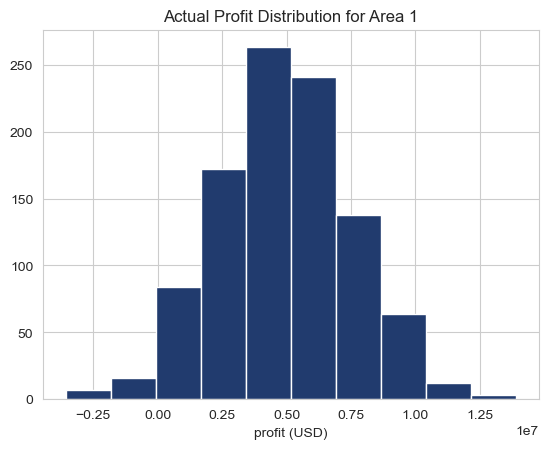

In [43]:
fig, ax = plt.subplots()
ax.hist(profits1)
ax.set(title = 'Actual Profit Distribution for Area 1', xlabel = 'profit (USD)')
plt.show()

In [44]:
print(f'The mean from bootstrapping 1000 trials with 500 samples is {mean1:,.2f} and the standard deviation is {std1:,.2f}')
print(f'The 95% confidence interval for the actual profit is in the range of {lower1:,.2f} USD to {upper1:,.2f} USD')
print(f'The probability that the loss is higher than 2.5% for the first area is {risk_pct1:.2f}%')

The mean from bootstrapping 1000 trials with 500 samples is 4,897,860.35 and the standard deviation is 2,625,930.17
The 95% confidence interval for the actual profit is in the range of 75,034.87 USD to 10,014,070.66 USD
The probability that the loss is higher than 2.5% for the first area is 0.30%


#### Geo Area 2

In [45]:
profits2, mean2, std2, sem2, lower2, upper2, risk_pct2 = bootstrap(target_valid2,predicted_valid2,1000)

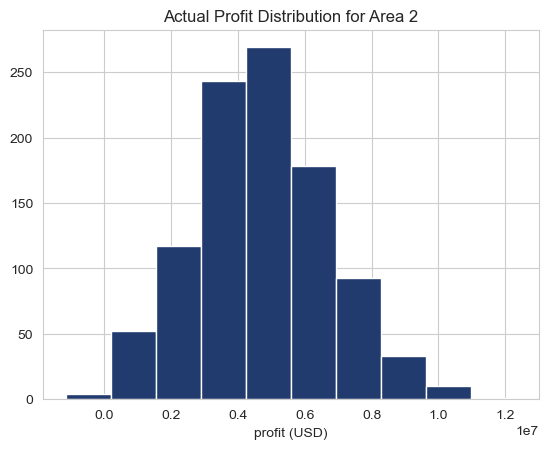

In [46]:
fig, ax = plt.subplots()
ax.hist(profits2)
ax.set(title = 'Actual Profit Distribution for Area 2', xlabel = 'profit (USD)')
plt.show()

In [47]:
print(f'The mean from bootstrapping 1000 trials with 500 samples is {mean2:,.2f} and the standard deviation is {std2:,.2f}')
print(f'The 95% confidence interval for the actual profit is in the range of {lower2:,.2f} USD to {upper2:,.2f} USD')
print(f'The probability that the loss is higher than 2.5% for the second area is {risk_pct2:.2f}%')

The mean from bootstrapping 1000 trials with 500 samples is 4,718,709.83 and the standard deviation is 2,006,191.08
The 95% confidence interval for the actual profit is in the range of 774,117.07 USD to 8,794,614.51 USD
The probability that the loss is higher than 2.5% for the second area is 0.00%


#### Geo Area 3

In [48]:
profits3, mean3, std3, sem3, lower3, upper3, risk_pct3 = bootstrap(target_valid3,predicted_valid3,1000)

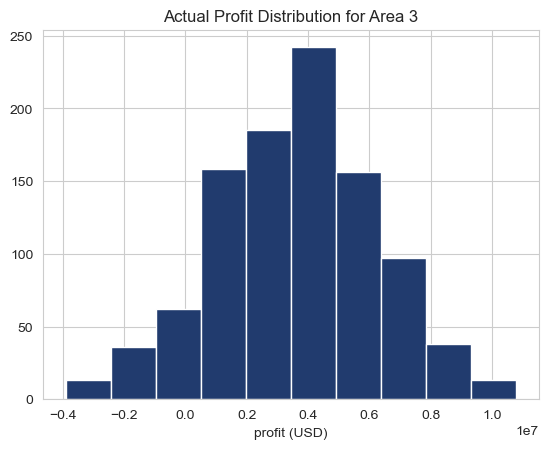

In [49]:
fig, ax = plt.subplots()
ax.hist(profits3)
ax.set(title = 'Actual Profit Distribution for Area 3', xlabel = 'profit (USD)')
plt.show()

In [50]:
print(f'The mean from bootstrapping 1000 trials with 500 samples is {mean3:,.2f} and the standard deviation is {std3:,.2f}')
print(f'The 95% confidence interval for the actual profit is in the range of {lower3:,.2f} USD to {upper3:,.2f} USD')
print(f'The probability that the loss is higher than 2.5% for the third area is {risk_pct3:.2f}%')

The mean from bootstrapping 1000 trials with 500 samples is 3,612,475.10 and the standard deviation is 2,616,496.24
The 95% confidence interval for the actual profit is in the range of -1,609,941.30 USD to 8,834,028.34 USD
The probability that the loss is higher than 2.5% for the third area is 1.20%


[back to table of contents](#back)

## 7. General Conclusion <a id='end'></a>

We start the research by evaluating the dataset. From this initial exploration, we found no missing values, duplicated data, invalid data, or redundant columns. Looking at the distribution of the data, we assume that there is no outlier in the dataset. After that, we split the dataset into training and validation dataset, with 25% of the data goes to validation dataset. Then we train linear regression model for each dataset. Based on the prediction, the third area has the highest average production prediction out of all followed by the first and second area consecutively. However, the model also has the largest variation in prediction out of all.

With the budget of 100 million USD to develop 200 wells, the total oil volume generated should be **22,222 MBBL** for the investment to breakeven assuming the price stays constant at 4.5 USD/BBL. On average, each well should be able to generate **111.11 MBBL**. By average, third area is the most likely to generate oil surpassing the minimum requirement. With the loss risk tolerance at 2.5%, the minimum requirement for each well is **108.33 MBBL**.

After sorting production by the predicted value and picking top 200 locations, the first area has the highest actual production and profit, followed by the third and second area. Based on **bootstrapping** each area, the second area is found to have the lowest possibility to generate loss followed by the first area and third area. The confidence interval for second area is in the range of positive values. Therefore, it is encouraged to build the new well in the **second area**.

[back to table of contents](#back)